# Model Evaluation of NeoPrecis-Immuno

This notebook is for evaluating immunogenicity prediction. 

The data is presented in Table S2-3, and the results are shown in Figure 2-3.

In [1]:
# path

#cedar_file = 'TableS2.csv' # fill in the path of TableS2.csv
#nci_file = 'TableS3.csv'  # fill in the path of TableS3.csv

cedar_file = '/cellar/users/kol004/neoantigen/manuscript/tables/cedar.csv'
nci_file = '/cellar/users/kol004/neoantigen/manuscript/tables/nci.csv'
out_dir = '/cellar/users/kol004/neoantigen/manuscript/plots/np_immuno_eval'
savefig = True

In [2]:
from imm_utils import *

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

# model color map
models = ['NP-Immuno', 'NetMHCpan', 'DeepNeo', 'PRIME', 'ICERFIRE']
metric_color_dict = {models[i]: sns.color_palette('pastel')[i] for i in range(len(models))}
metric_color_dict['PHBR'] = metric_color_dict['NetMHCpan']
metric_color_dict['NetMHCIIpan'] = metric_color_dict['NetMHCpan']

### Validation on the CEDAR immunogenicity dataset

In [ ]:
# loading CEDAR data

cedar_df = pd.read_csv(cedar_file)

#### all testing

In [ ]:
# evaluation with bootstrapping (only MHC-I)

x_col_dict = {
    'MT_netMHCpan_rank': 'less',
    'PRIME': 'less',
    'ICERFIRE': 'less',
    'DeepNeo': 'greater',
    'NeoPrecis-Immuno': 'greater'
}
y_col = 'label'

# testing set
test_df = cedar_df[(cedar_df[['in_prime', 'in_icerfire', 'in_deepneo']] == False).all(axis=1)] # not present in other predictors' training set
test_df = test_df[~test_df['dataset'].isin(['train', 'valid'])] # not in our training set
test_df = test_df[test_df['MHC']=='I'] # only MHC-I
test_df = test_df.dropna(subset=['PRIME', 'ICERFIRE', 'DeepNeo'])
print('#Samples =', test_df.shape[0])

# result
perf_df = Performance(test_df, x_col_dict, y_col, fillna=False) # performance
print(perf_df)

# bootstrapping
bstp_df = Bootstrapping(test_df, x_col_dict, y_col, fillna=False, n_iter=1000)

In [ ]:
# plot - AUROC

metric = 'AUROC'

# df
plot_df = bstp_df.copy()
plot_df['Model'] = plot_df['Model'].replace({'MT_netMHCpan_rank': 'NetMHCpan', 'NeoPrecis-Immuno': 'NP-Immuno'})

# plot
order_list = ['NP-Immuno', 'NetMHCpan', 'DeepNeo', 'PRIME', 'ICERFIRE']
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=dpi)
g = sns.boxplot(data=plot_df, x='Model', y=metric, order=order_list, ax=ax)
ax.tick_params(axis='x', rotation=60)
_ = ax.set_xlabel('')

# color
for i, patch in enumerate(g.patches):
    patch.set_facecolor(metric_color_dict[order_list[i]])

# save
fig.tight_layout()
if savefig:
    fig.savefig(f'{out_dir}/cedar_test_auroc.png')

In [ ]:
# plot - AUPRC

metric = 'AUPRC'

# df
plot_df = bstp_df.copy()
plot_df['Model'] = plot_df['Model'].replace({'MT_netMHCpan_rank': 'NetMHCpan', 'NeoPrecis-Immuno': 'NP-Immuno'})

# plot
order_list = ['NP-Immuno', 'NetMHCpan', 'DeepNeo', 'PRIME', 'ICERFIRE']
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=dpi)
g = sns.boxplot(data=plot_df, x='Model', y=metric, order=order_list, ax=ax)
ax.tick_params(axis='x', rotation=60)
_ = ax.set_xlabel('')

# color
for i, patch in enumerate(g.patches):
    patch.set_facecolor(metric_color_dict[order_list[i]])

# save
fig.tight_layout()
if savefig:
    fig.savefig(f'{out_dir}/cedar_test_auprc.png')

#### positive : negative = 1 : 3

In [ ]:
# filtering
test_df = cedar_df[(cedar_df[['in_prime', 'in_icerfire', 'in_deepneo']] == False).all(axis=1)] # not present in other predictors' training set
test_df = test_df[~test_df['dataset'].isin(['train', 'valid'])] # not in our training set
test_df = test_df[test_df['MHC']=='I'] # only MHC-I
test_df = test_df.dropna(subset=['PRIME', 'ICERFIRE', 'DeepNeo'])
test_df['length'] = test_df['WT_pept'].apply(lambda x: len(x))

In [ ]:
# bootstrapping
pred_cols = ['NeoPrecis-Immuno', 'PRIME', 'ICERFIRE', 'DeepNeo', 'MT_netMHCpan_rank']
pred_col_dict = {col: ('less' if col in ['MT_netMHCpan_rank', 'PRIME', 'ICERFIRE'] else 'greater') for col in pred_cols}
label_col = 'label'
p_n_ratio = 0.333
result_df = BootstrappingPN(test_df, pred_col_dict, label_col, p_n_ratio=p_n_ratio, fillna=True, n_iter=1000)

In [ ]:
# plot
plot_df = result_df.copy()
plot_df['Model'] = plot_df['Model'].replace({'MT_netMHCpan_rank': 'NetMHCpan', 'NeoPrecis-Immuno': 'NP-Immuno'})
order_list = ['NP-Immuno', 'NetMHCpan', 'DeepNeo', 'PRIME', 'ICERFIRE']

fig, ax = plt.subplots(1, 2, figsize=(7,3), dpi=dpi)
sns.boxplot(data=plot_df, x='Model', y='AUROC', hue='Model', order=order_list, palette=metric_color_dict, ax=ax[0])
sns.boxplot(data=plot_df, x='Model', y='AUPRC', hue='Model', order=order_list, palette=metric_color_dict, ax=ax[1])
_ = ax[0].set_xlabel('')
_ = ax[1].set_xlabel('')
ax[0].tick_params(axis='x', labelrotation=45)
ax[1].tick_params(axis='x', labelrotation=45)

fig.tight_layout()
fig.savefig(f'{out_dir}/cedar_test_balance.png')

### Validation on the NCI dataset

In [3]:
# load NCI data

nci_df = pd.read_csv(nci_file)

In [4]:
# filtered by abundance and presentation
def NCI_comparison(mut_df, mhc, x_cols, y_col, dropna=False):
    # x_cols
    x_col_dict = {f'{col}-{mhc}': ('less' if col in ['PHBR', 'PRIME', 'ICERFIRE'] else 'greater') for col in x_cols}
    x_col_dict = {k:v for k,v in x_col_dict.items() if k in mut_df.columns}

    # filtering
    print('#Samples =', mut_df.shape[0])
    filter_mut_df = mut_df[(mut_df['DNA_AF']>0) & (mut_df['RNA_AF']>0) & (mut_df['RNA_EXP_QRT']>1)] # filter by expression
    print('Filtered by abundance =', filter_mut_df.shape[0])
    filter_mut_df = filter_mut_df[filter_mut_df['Consequence']=='missense_variant'] # focus on substitutions
    print('Filtered by SNVs =', filter_mut_df.shape[0])
    filter_mut_df = filter_mut_df.dropna(subset=[f'PHBR-{mhc}']) # drop invalid mutations
    print('Filtered by valid PHBR =', filter_mut_df.shape[0])
    filter_mut_df = filter_mut_df[filter_mut_df[f'Robustness-{mhc}']>0]
    print('Filtered by robustness>0 =', filter_mut_df.shape[0])
    if dropna:
        cols = list(x_col_dict.keys()) + [y_col,]
        filter_mut_df = filter_mut_df.dropna(subset=cols) # drop NA
        print('Filtered by NA =', filter_mut_df.shape[0])

    # validation
    results = Performance(filter_mut_df, x_col_dict, y_col, fillna=True)

    return filter_mut_df, results

===MHCI===
#Samples = 7384
Filtered by abundance = 1774
Filtered by SNVs = 1674
Filtered by valid PHBR = 1674
Filtered by robustness>0 = 1448
Filtered by NA = 1088
===MHCII===
#Samples = 7384
Filtered by abundance = 1774
Filtered by SNVs = 1674
Filtered by valid PHBR = 1665
Filtered by robustness>0 = 1373
Filtered by NA = 1036


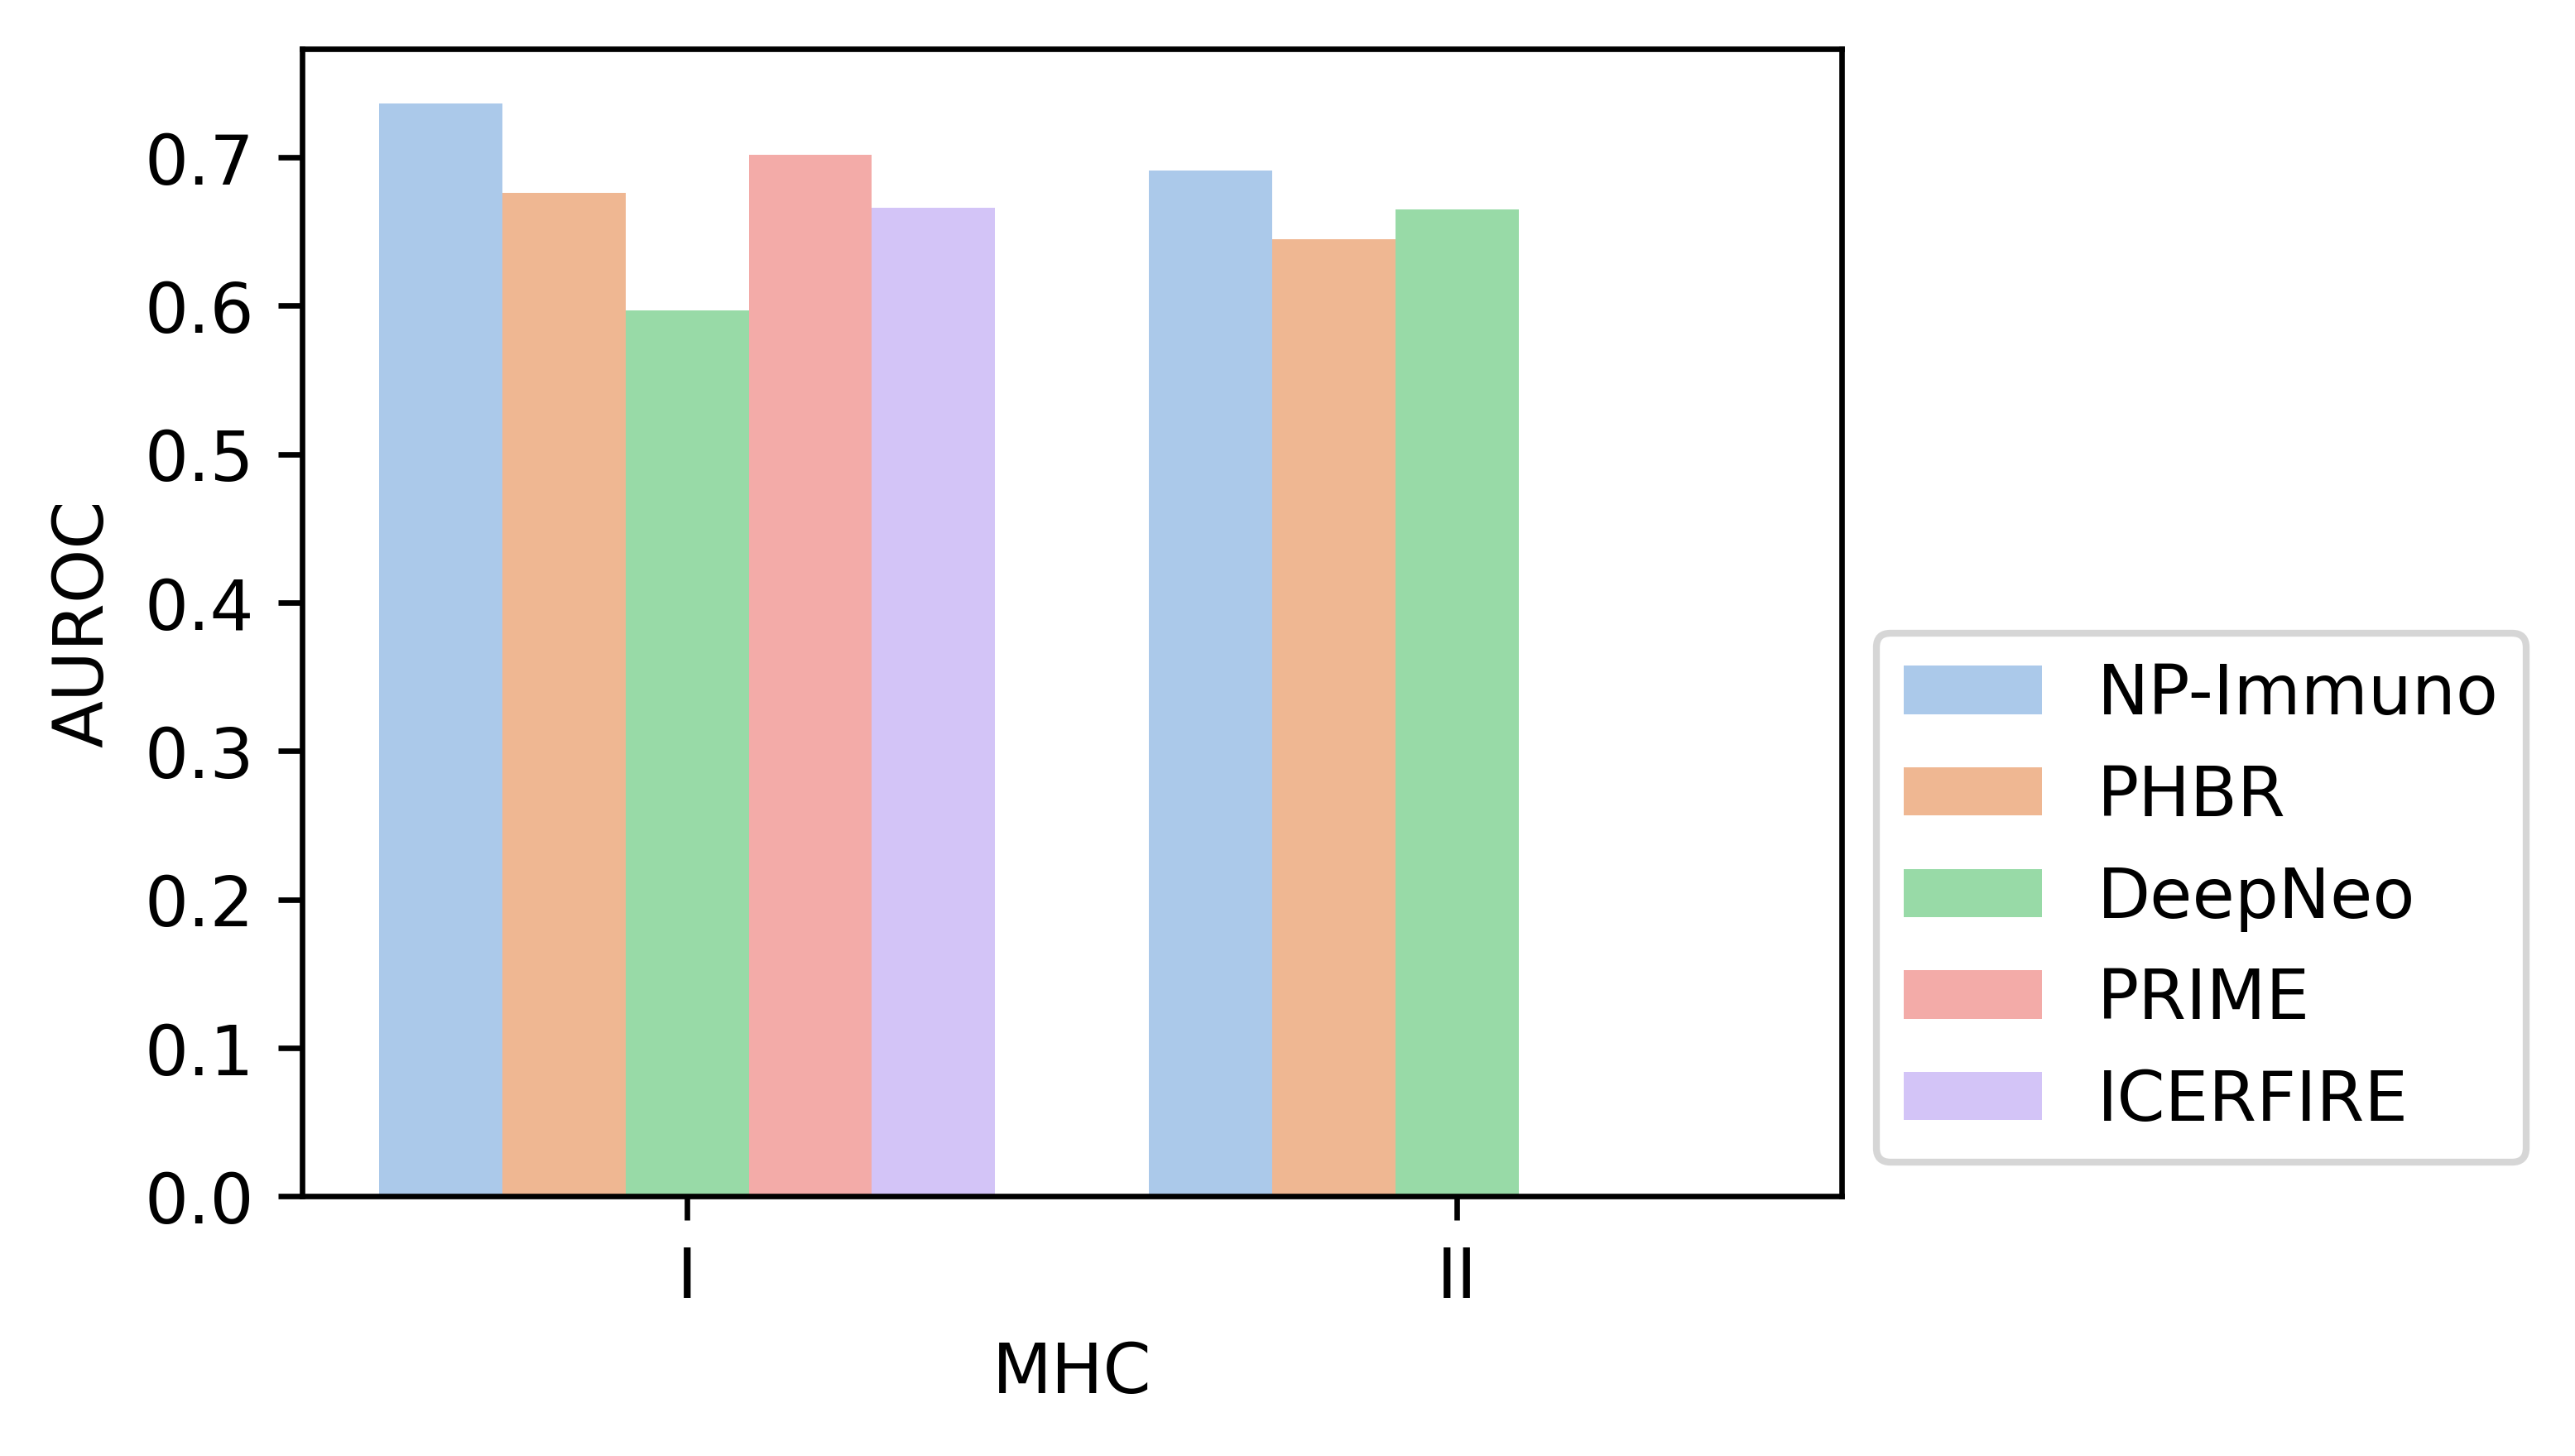

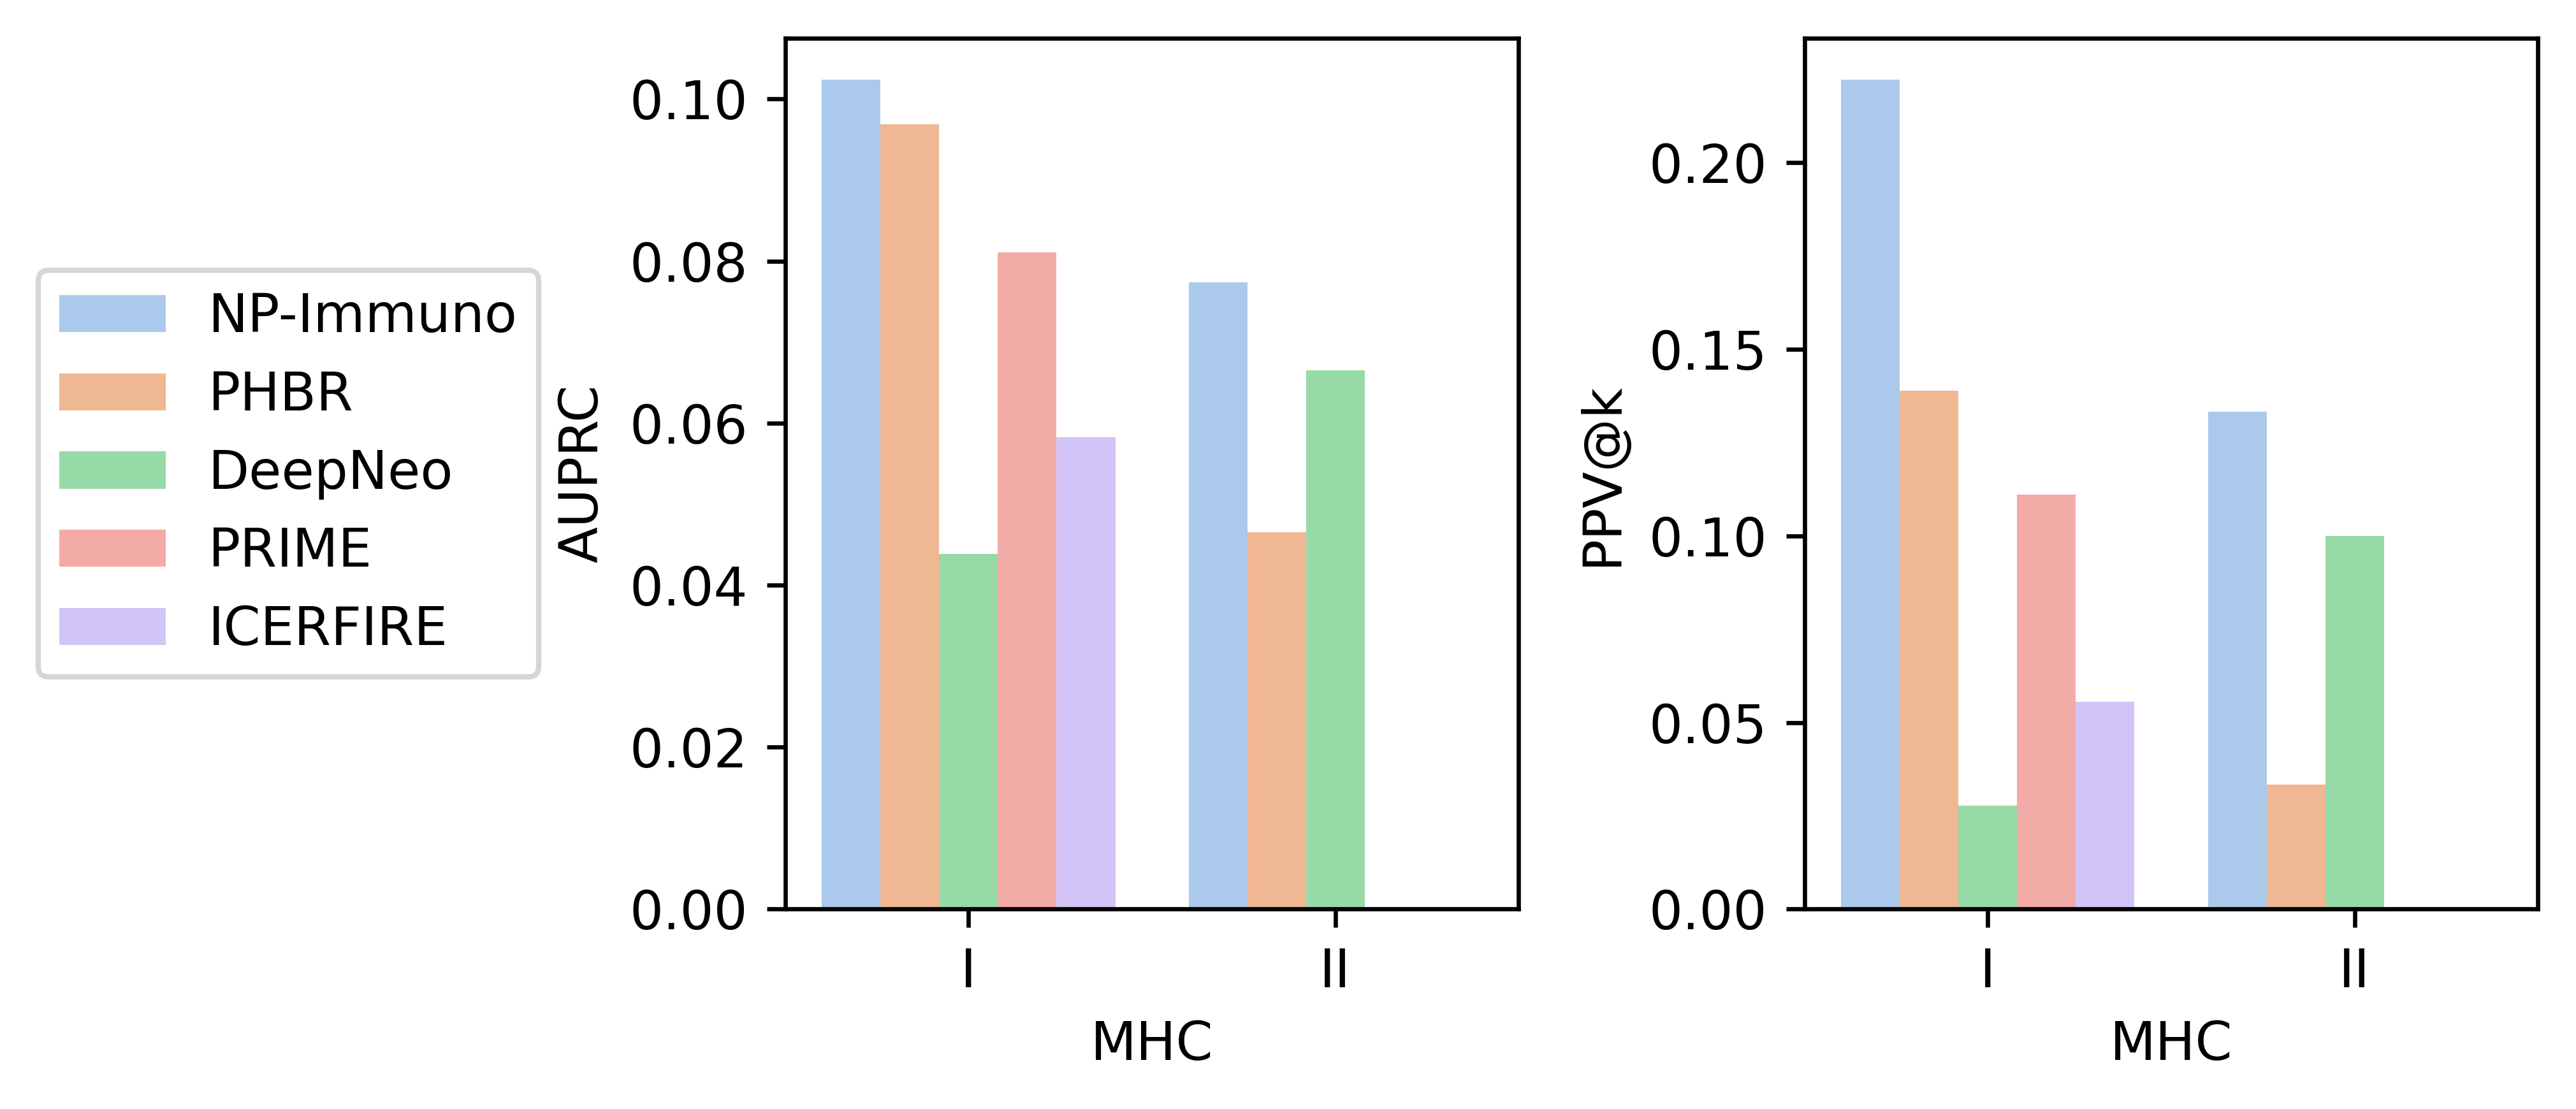

In [7]:
### comparing with other methods
# drop NA

methods = ['NP-Immuno', 'PHBR', 'DeepNeo', 'PRIME', 'ICERFIRE']

print('===MHCI===')
mhci_filter_mut_df, mhci_results = NCI_comparison(nci_df, 'I', methods, 'CD8', dropna=True) # drop NA to ensure all samples with predictions
print('===MHCII===')
mhcii_filter_mut_df, mhcii_results = NCI_comparison(nci_df, 'II', methods, 'CD4', dropna=True)

# rename PPV@k (k=#positives)
mhci_results = mhci_results.rename(columns={f'PPV@{mhci_filter_mut_df["CD8"].sum()}': 'PPV@k'})
mhcii_results = mhcii_results.rename(columns={f'PPV@{mhcii_filter_mut_df["CD4"].sum()}': 'PPV@k'})

# plot
figfile = f'{out_dir}/nci_test_auroc.png' if savefig else None
TwoPerfBarPlot(mhci_results, mhcii_results, methods, 'AUROC', palette=metric_color_dict, hue_order=methods, figsize=(4,3), figfile=figfile)

fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=dpi)
TwoPerfBarPlot(mhci_results, mhcii_results, methods, 'AUPRC', palette=metric_color_dict, hue_order=methods, ax=ax[0])
TwoPerfBarPlot(mhci_results, mhcii_results, methods, 'PPV@k', palette=metric_color_dict, hue_order=methods, ax=ax[1])
ax[1].legend_.remove()
sns.move_legend(ax[0], loc='center right', bbox_to_anchor=(-.3, 0.5))
fig.tight_layout()
if savefig:
    fig.savefig(f'{out_dir}/nci_test.png')

In [ ]:
### component contribution
# fill NA with 0

methods = ['BLOSUMDist', 'PMBECDist', 'SubDist', 'SubPosDist', 'GeoDist', 'CRD']
metric = 'AUROC'

print('===MHCI===')
mhci_filter_mut_df, mhci_results = NCI_comparison(nci_df, 'I', methods, 'CD8', dropna=False)
print('===MHCII===')
mhcii_filter_mut_df, mhcii_results = NCI_comparison(nci_df, 'II', methods, 'CD4', dropna=False)

figfile = f'{out_dir}/nci_components.png' if savefig else None
TwoPerfBarPlot(mhci_results, mhcii_results, methods, metric, palette='pastel', figsize=(7,3), annot=True)

In [ ]:
### component correlation

cols = ['BLOSUMDist', 'PMBECDist', 'SubDist', 'SubPosDist', 'GeoDist', 'CRD']
mhci_cols = [f'{col}-I' for col in cols]
mhcii_cols = [f'{col}-II' for col in cols]

# corr
mhci_corr_df = mhci_filter_mut_df[mhci_cols].corr()
mhcii_corr_df = mhcii_filter_mut_df[mhcii_cols].corr()

# plot
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=dpi, gridspec_kw={'width_ratios': [0.45, 0.55]})
sns.heatmap(mhci_corr_df, cmap='Blues', ax=ax[0], vmin=0, vmax=1, cbar=False, annot=True)
sns.heatmap(mhcii_corr_df, cmap='Blues', ax=ax[1], vmin=0, vmax=1, annot=True)
_ = ax[0].set_xticklabels(cols)
_ = ax[1].set_xticklabels(cols)
_ = ax[0].set_yticklabels(cols)
_ = ax[1].set_yticklabels('')
_ = ax[1].set_yticks([])
_ = ax[0].set_title('MHC-I')
_ = ax[1].set_title('MHC-II')

fig.tight_layout()
if savefig:
    fig.savefig(f'{out_dir}/nci_component_corr.png')